<a href="https://colab.research.google.com/github/BernaTasel/colabWorks/blob/main/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#kütüphaneler
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics

import time

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
#drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#rename the files
import os
for count, filename in enumerate(os.listdir("drive/My Drive/DietApp/PlateDataSet/non-plate/")):
  dst ="non-plate-" + str(count) + ".jpg"
  src ='drive/My Drive/DietApp/PlateDataSet/non-plate/' + filename 
  dst ='drive/My Drive/DietApp/PlateDataSet/non-plate/'+ dst
  os.rename(src, dst) 


In [ ]:
#rename the files
import os
for count, filename in enumerate(os.listdir("drive/My Drive/DietApp/PlateDataSet/plate/")):
  dst ="plate-" + str(count) + ".jpg"
  src ='drive/My Drive/DietApp/PlateDataSet/plate/' + filename 
  dst ='drive/My Drive/DietApp/PlateDataSet/plate/'+ dst
  os.rename(src, dst) 


In [3]:
import os
data = 'drive/My Drive/DietApp/PlateDataSet'
folders = os.listdir(data)
print(folders)

['resized-plate', 'resized-non-plate']


In [4]:
DATASET = 'drive/My Drive/DietApp/PlateDataSet'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018

def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(DATASET):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [5]:
# Split the images into train and test sets.
splitDatasetTime = 0
i = 0
beforeSplit = time.time()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)
afterSplit = time.time()
splitDatasetTime = afterSplit - beforeSplit
print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))
print("Split Time: "+ str(splitDatasetTime))


The dataset has 2 label classes: odict_values(['resized-non-plate', 'resized-plate'])
There are 11168 training images
there are 2792 test images
Split Time: 11.818027257919312


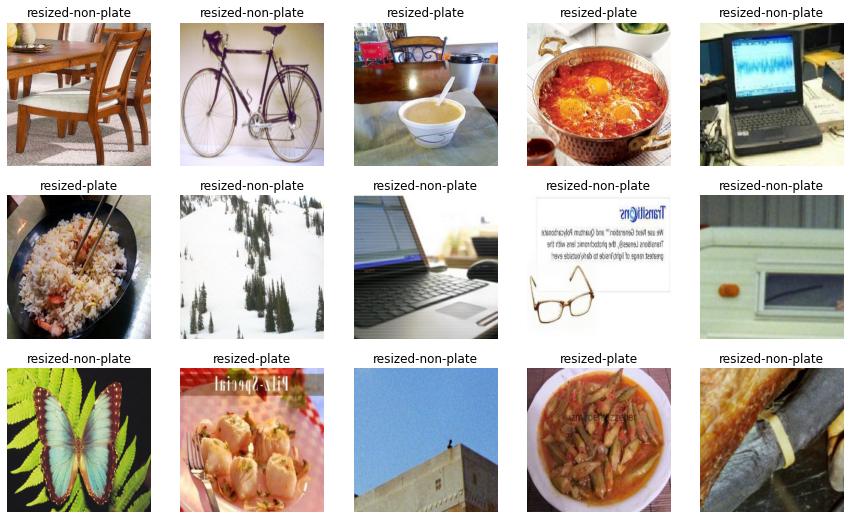

In [6]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, data_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(data_class)

NUM_IMAGES = 15 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

In [9]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [11]:
learningTime = 0
startTime = time.time()

# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 300 #@param {type: 'integer'}
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 #@param {type: 'integer'}
# How often to evaluate the model performance.
EVAL_EVERY = 10 #@param {type: 'integer'}

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))


finishTime = time.time()
learningTime = finishTime - startTime
print(learningTime)

Test accuracy at step 0: 47.35%
Test accuracy at step 10: 81.81%
Test accuracy at step 20: 85.14%
Test accuracy at step 30: 87.36%
Test accuracy at step 40: 88.86%
Test accuracy at step 50: 91.01%
Test accuracy at step 60: 91.94%
Test accuracy at step 70: 90.90%
Test accuracy at step 80: 92.01%
Test accuracy at step 90: 92.08%
Test accuracy at step 100: 92.77%
Test accuracy at step 110: 92.62%
Test accuracy at step 120: 93.02%
Test accuracy at step 130: 93.12%
Test accuracy at step 140: 93.16%
Test accuracy at step 150: 92.41%
Test accuracy at step 160: 92.91%
Test accuracy at step 170: 93.19%
Test accuracy at step 180: 93.34%
Test accuracy at step 190: 93.48%
Test accuracy at step 200: 93.80%
Test accuracy at step 210: 93.70%
Test accuracy at step 220: 93.30%
Test accuracy at step 230: 93.45%
Test accuracy at step 240: 93.37%
Test accuracy at step 250: 93.80%
Test accuracy at step 260: 93.84%
Test accuracy at step 270: 93.91%
Test accuracy at step 280: 93.98%
Test accuracy at step 290

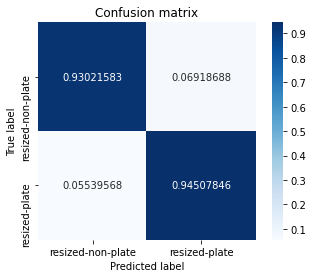

In [16]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.8f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)


In [ ]:
#Display wrong prediction
